In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torchvision
import torchsummary
import PIL
from matplotlib import pyplot as plt
import numpy as np

import utils
import datasets
from models import SRCNN
from models import PartialConv2d
from models import PConvSR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


In [4]:
batch_size = 32
div2k = datasets.Div2K(32, 2)
training_set, validation_set, test_set = torch.utils.data.random_split(div2k, [640,80,80])
# lr, hr = div2k[0]
# print(lr.shape)
# utils.showImages([lr, hr])


In [5]:
# x = torch.rand((16, 3, 64, 64)).to(device)
# mask_in = torch.zeros((16, 3, 64, 64)).to(device)
# mask_in[0,0,0,0] = 1
# model(x, mask_in)

def image_mask(x, factor):
    new_dims = tuple([x.shape[0], x.shape[1], x.shape[2]*factor, x.shape[3]*factor])
    out = torch.zeros(new_dims)
    out[:,:,::2,::2] = x[:,:,:,:]
    mask = torch.zeros(new_dims)
    mask[:,:,::2,::2] = 1
    return out, mask

# x = torch.rand((32, 3, 64, 64))
# image_mask(x, 2)


In [6]:
training_dataloader = torch.utils.data.DataLoader(training_set, batch_size=batch_size)
validation_dataloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

model = PConvSR().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loss_func = torch.nn.MSELoss()

torchsummary.summary(model, input_size=[(3, 64, 64), (3, 64, 64)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
     PartialConv2d-1  [[-1, 64, 64, 64], [-1, 64, 64, 64]]          15,616
     PartialConv2d-2  [[-1, 32, 64, 64], [-1, 32, 64, 64]]          51,232
     PartialConv2d-3  [[-1, 3, 64, 64], [-1, 3, 64, 64]]           2,403
Total params: 69,251
Trainable params: 69,251
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 576.00
Forward/backward pass size (MB): 656512.00
Params size (MB): 0.26
Estimated Total Size (MB): 657088.26
----------------------------------------------------------------


In [7]:
# basic training loop
for epoch in range(32):
    for i, batch in enumerate(training_dataloader):
        # TODO make sure ops happen on GPU, unless the speed isn't affected
        optimizer.zero_grad()

        lr, hr = batch
        lr, hr = lr.to(device), hr.to(device)
        with torch.no_grad():
            upscaled, mask_in = image_mask(lr, 2)

        pred, mask_out = model(upscaled.to(device), mask_in.to(device))
        loss = loss_func(pred, hr)
        loss.backward()

        optimizer.step()

        #print(i, loss)
    # basic validation loop
    print(f"Epoch {epoch}")
    for i, batch in enumerate(validation_dataloader):
        with torch.no_grad():
            lr, hr = batch
            lr, hr = lr.to(device), hr.to(device)
            with torch.no_grad():
                upscaled, mask_in = image_mask(lr, 2)

            pred, mask_out = model(upscaled.to(device), mask_in.to(device))
            loss = loss_func(pred, hr)
            print(i, loss)

Epoch 0
0 tensor(0.0169, device='cuda:0')
1 tensor(0.0144, device='cuda:0')
2 tensor(0.0199, device='cuda:0')
Epoch 1
0 tensor(0.0092, device='cuda:0')
1 tensor(0.0071, device='cuda:0')
2 tensor(0.0135, device='cuda:0')
Epoch 2
0 tensor(0.0067, device='cuda:0')
1 tensor(0.0051, device='cuda:0')
2 tensor(0.0105, device='cuda:0')
Epoch 3
0 tensor(0.0053, device='cuda:0')
1 tensor(0.0042, device='cuda:0')
2 tensor(0.0084, device='cuda:0')
Epoch 4
0 tensor(0.0041, device='cuda:0')
1 tensor(0.0033, device='cuda:0')
2 tensor(0.0068, device='cuda:0')
Epoch 5
0 tensor(0.0039, device='cuda:0')
1 tensor(0.0032, device='cuda:0')
2 tensor(0.0061, device='cuda:0')
Epoch 6
0 tensor(0.0030, device='cuda:0')
1 tensor(0.0025, device='cuda:0')
2 tensor(0.0051, device='cuda:0')
Epoch 7
0 tensor(0.0027, device='cuda:0')
1 tensor(0.0023, device='cuda:0')
2 tensor(0.0047, device='cuda:0')
Epoch 8
0 tensor(0.0025, device='cuda:0')
1 tensor(0.0021, device='cuda:0')
2 tensor(0.0045, device='cuda:0')
Epoch 9
0 

In [8]:
# basic testing loop
print("Testing")
for i, batch in enumerate(test_dataloader):
    with torch.no_grad():
        lr, hr = batch
        lr, hr = lr.to(device), hr.to(device)
        with torch.no_grad():
            upscaled, mask_in = image_mask(lr, 2)

        pred, mask_out = model(upscaled.to(device), mask_in.to(device))
        loss = loss_func(pred, hr)
        print(i, loss)

Testing
0 tensor(0.0022, device='cuda:0')
1 tensor(0.0021, device='cuda:0')
2 tensor(0.0029, device='cuda:0')


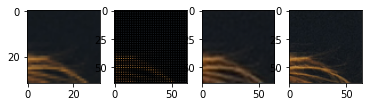

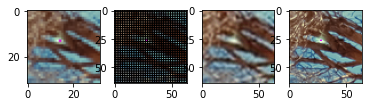

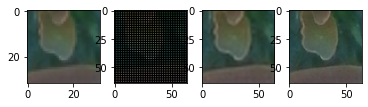

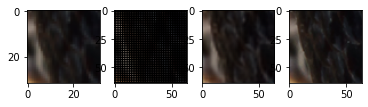

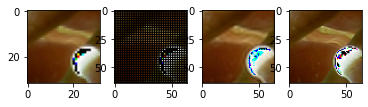

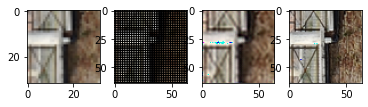

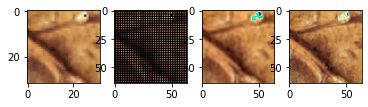

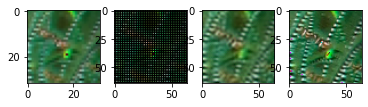

In [14]:
for i in range(8):
    with torch.no_grad():
        lr, hr = test_set[i+8]
        batch = utils.example_batch(torch.tensor(lr).to(device), batch_size)
        upscaled, mask_in = image_mask(batch, 2)
        pred, _ = model(upscaled.to(device), mask_in.to(device))
        utils.showImages([np.asarray(lr), np.array(upscaled[0].cpu()), np.array(pred[0].cpu()), hr])